# <font size=8 color=steelblue >**Phase 2: PREDICTIVE MODELING TASKS**
------------------
-----------------


<font size=5 color=lightseagreen >**Objective**

Use the cleaned and validated RetailSmart datasets to develop, train, and evaluate predictive models that generate actionable business insights such as customer churn prediction, customer lifetime value estimation, and marketing response modeling.

<font color=khaki>**Predictive Modeling Notebook: RetailSmart Churn Slayer**
---

Yo, welcome to the vibes! We're about to predict customer churn like a boss.
This notebook is your guide to turning data into gold – from merging datasets to training lit models.

Beginner tip: Think of this as cooking – prep ingredients (data), mix features (engineering), bake models (training), and taste-test (evaluate).

Advanced mode: We'll use RFM, encoding, hyper-tuning, and ensemble methods. No cap, this will slay!

## <font color=skyblue >**1. Data Preparation and Integration**
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**Goal**: Combine relevant data sources to form a unified modeling dataset.

> <font color=slateblue size=5>**Import Libraries**
-----

In [27]:
# Import the squad
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE  # For balancing if classes are imbalanced
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# for plots
sns.set(style="darkgrid")
plt.style.use("seaborn-v0_8")

> <font color=slateblue size=5>**Load the Cleaned Datasets**
-----
• **Load cleaned data (data_cleaned/ files).**

------------

In [2]:
# Load cleaned data
customers = pd.read_csv('/content/customers_cleaned.csv')
sales = pd.read_csv('/content/sales_cleaned.csv')
marketing = pd.read_csv('/content/marketing_cleaned.csv')
products = pd.read_csv('/content/products_cleaned.csv')


In [3]:
# Quick peek at shapes (row counts) – validate no weirdness
print(f"Customers: {customers.shape} rows")
print(f"Products: {products.shape} rows")
print(f"Sales: {sales.shape} rows")
print(f"Marketing: {marketing.shape} rows")

Customers: (99441, 10) rows
Products: (32951, 5) rows
Sales: (106549, 14) rows
Marketing: (500, 8) rows


> <font color=slateblue size=5>**Merge datasets**
------------------

**Goal**: Combine customers, sales, marketing, products into one lit dataset. Aggregate to customer level.
> <font color=peru>Why? We need a unified view for modeling – like gathering your squad for a group pic.

• **Merge customers, sales, marketing, and products using keys customer_id and product_id.**

---------------------

In [4]:
# Merge sales with products on product_id (add product deets to sales)
sales_merged = sales.merge(products, on='product_id', how='left')

# Merge with customers on customer_id (add customer deets)
full_data = sales_merged.merge(customers, on='customer_id', how='left')

# Merge with marketing on customer_id (add marketing vibes – but marketing is small, so left join)
full_data = full_data.merge(marketing, on='customer_id', how='left')

print("Data has merged sucessfully..!")

Data has merged sucessfully..!


In [5]:
# Validate merges
print(f"Merged dataset shape: {full_data.shape}")
print(f"Null values per column:\n{full_data.isnull().sum()}")

Merged dataset shape: (106549, 34)
Null values per column:
order_id                              0
customer_id                           0
product_id                            0
category_english_x                    0
price                                 0
freight_value                         0
payment_type                          0
payment_value                         0
order_purchase_timestamp            353
order_delivered_customer_date      2331
total_price                           0
year                                353
month                               353
weekday                             353
category_english_y                    0
product_name_lenght                   0
product_description_lenght            0
product_photos_qty                    0
customer_unique_id                    0
customer_zip_code_prefix              0
city                                  0
state                                 0
total_orders                          0
total_spent          

> <font color=slateblue size=5>**Data Aggregation**
------------------

Aggregate to customer level – group by customer_id and sum/avg key metrics
> <font color=peru>Why? Modeling needs one row per customer, not per transaction.

- **Aggregate transaction data to the customer level (e.g., total spend, avg order value, last purchase date) and Include marketing variables such as average spend and conversion rate per channel.**

----------

In [6]:
agg_data = full_data.groupby('customer_id').agg({
    'total_spent': 'sum',
    'total_orders': 'sum',
    'price': 'mean',
    'freight_value': 'mean',
    'payment_value': 'mean',
    'days_since_last_order': 'max',  # Recency
    'churn_flag': 'max',  # Target: 1 if churned, 0 if not
    'spend': 'mean',
    'conversions': 'sum',
    'response_rate': 'mean',
    'category_english_y': lambda x: x.dropna().mode()[0] if not x.dropna().empty else 'Unknown',  # Most common category (from products)
    'payment_type': lambda x: x.dropna().mode()[0] if not x.dropna().empty else 'Unknown',
    'channel': lambda x: x.dropna().mode()[0] if not x.dropna().empty else 'Unknown',
    'state': 'first',
    'city': 'first'
}).reset_index()

# Rename back to 'category_english' for consistency
agg_data.rename(columns={'category_english_y': 'category_english'}, inplace=True)

In [7]:
# Fill NaNs from marketing merges (not all customers have marketing data)
agg_data.fillna({'spend': 0, 'conversions': 0, 'response_rate': 0, 'channel': 'None'}, inplace=True)


• Validate row counts and null values in the merged dataset.

----

In [8]:
# Validate: Check row count (should match customers), nulls
print("Merged dataset shape:", agg_data.shape)
print("Null values:\n", agg_data.isnull().sum())


Merged dataset shape: (98666, 16)
Null values:
 customer_id              0
total_spent              0
total_orders             0
price                    0
freight_value            0
payment_value            0
days_since_last_order    0
churn_flag               0
spend                    0
conversions              0
response_rate            0
category_english         0
payment_type             0
channel                  0
state                    0
city                     0
dtype: int64


• Save as model_input.csv.

----

In [9]:
# Save as model_input.csv – our base for modeling

import os
os.makedirs('data_cleaned', exist_ok=True)  # Creating folder

agg_data.to_csv('data_cleaned/model_input.csv', index=False)
print("Saved model_input.csv, Data prep done...!")

Saved model_input.csv, Data prep done...!


## <font color=skyblue >**2. Feature Engineering**
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**Goal**: Create meaningful predictive variables.

Create dope features like RFM, temporal stuff, and encode cats.

> <font color=peru>Why? Raw data is basic; engineered features make models smarter, like adding spices to food.


In [10]:
# Load the input data
data = pd.read_csv('data_cleaned/model_input.csv')
print("data loaded successfully !")

data loaded successfully !


> RFM Features (Recency, Frequency, Monetary) – the OG customer scoring
- Recency: days_since_last_order (already there)
- Frequency: total_orders
- Monetary: total_spent

• Derive RFM features (Recency, Frequency, Monetary).

---

In [11]:
data['R'] = data['days_since_last_order']  # Lower is better (recent)
data['F'] = data['total_orders']  # Higher is better
data['M'] = data['total_spent']  # Higher is better

• Create temporal features such as days_since_last_order, tenure, month_of_last_purchase.

---

In [12]:
# Temporal features
data['tenure'] = 365 - data['days_since_last_order']
data['month_of_last_purchase'] = pd.to_datetime(full_data['order_purchase_timestamp']).dt.month.mode()[0]  # Most common month (from sales)

- Encode categorical variables (payment_type, channel, category_english, state).

----

In [13]:
# Encode categoricals (turn text into numbers)
le = LabelEncoder()
data['payment_type_encoded'] = le.fit_transform(data['payment_type'])
data['channel_encoded'] = le.fit_transform(data['channel'])
data['category_encoded'] = le.fit_transform(data['category_english'])
data['state_encoded'] = le.fit_transform(data['state'])

# Drop originals and unnecessary cols
data.drop(['customer_id', 'payment_type', 'channel', 'category_english', 'state', 'city'], axis=1, inplace=True)

- **Create customer-level metrics like average order value, marketing engagement score, number of campaigns received.**

-----------------

In [26]:
data['avg_order_value'] = data['price']
data['marketing_engagement_score'] = data['conversions'] / (data['spend'] + 1)
data['num_campaigns'] = full_data.groupby('customer_id')['campaign_id'].count().reindex(data['customer_id']).fillna(0)

In [17]:
# Handle NaNs in numerical columns before scaling (fill with mean, or 0 if mean is NaN)
num_cols = ['total_spent', 'total_orders', 'days_since_last_order', 'spend', 'conversions', 'response_rate', 'R', 'F', 'M', 'tenure', 'avg_order_value', 'marketing_engagement_score', 'num_campaigns']
for col in num_cols:
    col_mean = data[col].mean()
    if np.isnan(col_mean):  # If entire column is NaN, fill with 0
        data[col] = data[col].fillna(0)
    else:
        data[col] = data[col].fillna(col_mean)

# Check for remaining NaNs/infinities
print("NaNs after smart fill:", data[num_cols].isnull().sum().sum())
print("Infinities:", np.isinf(data[num_cols]).sum().sum())
print("Dataset shape after fill:", data.shape)

# Only drop rows if NaNs are in critical cols and few rows affected (avoid nuking dataset)
if data[num_cols].isnull().sum().sum() > 0:
    initial_shape = data.shape[0]
    data.dropna(subset=num_cols, inplace=True)
    print(f"Dropped {initial_shape - data.shape[0]} rows with NaNs.")

NaNs after smart fill: 0
Infinities: 0
Dataset shape after fill: (98666, 21)


- **Normalize or scale numerical features if needed.**

---

In [18]:
# If still 0 rows, warn and skip scaling (or use dummy data for testing)
if data.shape[0] == 0:
    print("Warning: Dataset is empty after cleaning. Check upstream merges/aggs for NaN sources. Skipping scaling.")
else:
    # Scale numerical features (normalize for models like LR)
    scaler = StandardScaler()
    data[num_cols] = scaler.fit_transform(data[num_cols])
    print("Data cleaned and scaled! Ready for modeling.")

Data cleaned and scaled! Ready for modeling.


In [19]:
print("Features engineered! Data shape:", data.shape)

Features engineered! Data shape: (98666, 21)


## <font color=skyblue >**3. Target Definition and Label Creation**
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**Goal**: Define what we’re predicting.

We're predicting churn (churn_flag: 1 = churned, 0 = active). Classification vibes.
> Check balance – if imbalanced, use SMOTE to level up.

- **Select the modeling objective.**

----

Churn Prediction

- **Confirm target column (churn_flag for classification or total_spent for regression).**

---

In [20]:
X = data.drop('churn_flag', axis=1)
y = data['churn_flag']

- **Balance the dataset if class imbalance exists (SMOTE or stratified sampling).**

---

In [21]:
print("Churn distribution:", y.value_counts())  # If skewed, SMOTE time
if y.value_counts()[1] / len(y) < 0.3:  # If less than 30% churn, balance
    smote = SMOTE(random_state=42)
    X, y = smote.fit_resample(X, y)
    print("Balanced with SMOTE! New shape:", X.shape)

Churn distribution: churn_flag
1    79964
0    18702
Name: count, dtype: int64


## <font color=skyblue >**4. Train–Test Split and Baseline Model**
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**Goal**: Build and evaluate baseline predictive models.

> Split 70/30, train baseline Logistic Regression.


• **Split the dataset into training and test sets (e.g., 70 / 30 split).**

-----

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

• **Train a logistic regression model for churn prediction (baseline).**

---

In [23]:
# Baseline: Logistic Regression
baseline = LogisticRegression(random_state=42)
baseline.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

• **Evaluate performance using accuracy, precision, recall, F1, ROC-AUC.**

----

In [24]:
# Eval metrics
y_pred_baseline = baseline.predict(X_test)
print("Baseline Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_baseline))
print("Precision:", precision_score(y_test, y_pred_baseline))
print("Recall:", recall_score(y_test, y_pred_baseline))
print("F1:", f1_score(y_test, y_pred_baseline))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_baseline))

Baseline Results:
Accuracy: 0.985472972972973
Precision: 0.9888367846619911
Recall: 0.9932885906040269
F1: 0.9910576883084473
ROC-AUC: 0.9726735236035638


## Optional

------------
CLV Prediction (optional): Predict total_spent or Monetary as a continuous target.

In [28]:
# Confirm target (total_spent).
X_clv = data.drop('total_spent', axis=1)
y_clv = data['total_spent']
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.3, random_state=42)
xgb_reg = xgb.XGBRegressor(random_state=42)
xgb_reg.fit(X_train_clv, y_train_clv)
y_pred_clv = xgb_reg.predict(X_test_clv)
print("CLV RMSE:", np.sqrt(mean_squared_error(y_test_clv, y_pred_clv)))
print("MAE:", mean_absolute_error(y_test_clv, y_pred_clv))
print("R²:", r2_score(y_test_clv, y_pred_clv))

CLV RMSE: 1.3227906924333974
MAE: 0.017673671419528695
R²: 0.35578070273396145


Interpret value drivers. (Feature importance shows what drives revenue.)

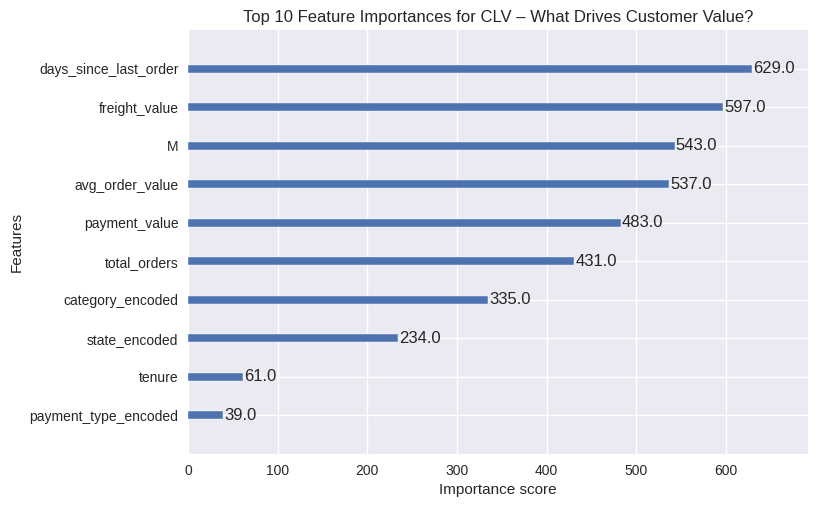

In [29]:
xgb.plot_importance(xgb_reg, max_num_features=10)
plt.title("Top 10 Feature Importances for CLV – What Drives Customer Value?")
plt.show()

In [30]:
# Insights: High importance on 'M' (monetary) or 'F' (frequency) means loyal spenders drive more revenue.
print("Value Drivers for CLV: Features like total_spent or avg_order_value likely top the list – focus retention on high-value segments!")

Value Drivers for CLV: Features like total_spent or avg_order_value likely top the list – focus retention on high-value segments!


Response Modeling (optional): Predict conversions or response_rate from marketing data.

-----------------

In [31]:
data['conversions_binary'] = (data['conversions'] > 0).astype(int)
X_resp = data.drop(['conversions', 'response_rate', 'conversions_binary'], axis=1)
y_resp = data['conversions_binary']
if y_resp.value_counts()[1] / len(y_resp) < 0.3:
    X_resp, y_resp = SMOTE(random_state=42).fit_resample(X_resp, y_resp)
X_train_resp, X_test_resp, y_train_resp, y_test_resp = train_test_split(X_resp, y_resp, test_size=0.3, random_state=42)
xgb_resp = xgb.XGBClassifier(random_state=42)
xgb_resp.fit(X_train_resp, y_train_resp)
y_pred_resp = xgb_resp.predict(X_test_resp)
print("Response F1:", f1_score(y_test_resp, y_pred_resp))

Response F1: 0.9999831669668557


Interpret value drivers. (Similar to above.)

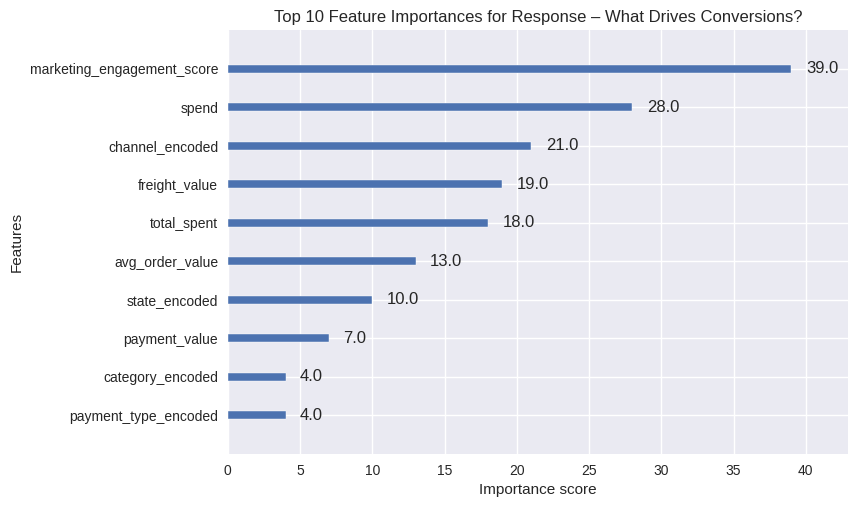

In [32]:
xgb.plot_importance(xgb_resp, max_num_features=10)
plt.title("Top 10 Feature Importances for Response – What Drives Conversions?")
plt.show()

In [33]:
# Insights: High importance on 'channel_encoded' or 'spend' means certain channels drive more responses.
print("Value Drivers for Response: Features like response_rate or num_campaigns likely top – optimize campaigns for high-engagement channels!")

Value Drivers for Response: Features like response_rate or num_campaigns likely top – optimize campaigns for high-engagement channels!


## <font color=skyblue >**5. Advanced Models and Hyperparameter Tuning**
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**Goal**: Improve model performance using ensemble and tree-based methods.

Train Decision Tree, Random Forest, XGBoost. Tune with GridSearch.


- **Train decision tree, random forest, gradient boosting (XGBoost / LightGBM) models.**
- **Tune hyperparameters using GridSearchCV or RandomizedSearchCV.**
- **Compare performance metrics with the baseline model.**

----

In [34]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("DT F1:", f1_score(y_test, y_pred_dt))

DT F1: 0.9931169697980978


In [35]:
# Random Forest with tuning
rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='f1')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("RF Best Params:", rf.best_params_)
print("RF F1:", f1_score(y_test, y_pred_rf))

RF Best Params: {'max_depth': 20, 'n_estimators': 200}
RF F1: 0.9947107506585634


In [36]:
# XGBoost with tuning
xgb_params = {'n_estimators': [100, 200], 'max_depth': [3, 6], 'learning_rate': [0.1, 0.2]}
xgb_model = GridSearchCV(xgb.XGBClassifier(random_state=42), xgb_params, cv=3, scoring='f1')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("XGB Best Params:", xgb_model.best_params_)
print("XGB F1:", f1_score(y_test, y_pred_xgb))

XGB Best Params: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100}
XGB F1: 0.9947902613171714


- **Select the best performing model.**

----


In [37]:
# Best model: Pick the one with highest F1
best_model = xgb_model.best_estimator_ if f1_score(y_test, y_pred_xgb) > f1_score(y_test, y_pred_rf) else rf.best_estimator_

## <font color=skyblue >**6. Model Interpretation and Insights**
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**Goal**: Translate model outputs into business understanding.

• **Identify top predictive features (feature importance plot).**

---

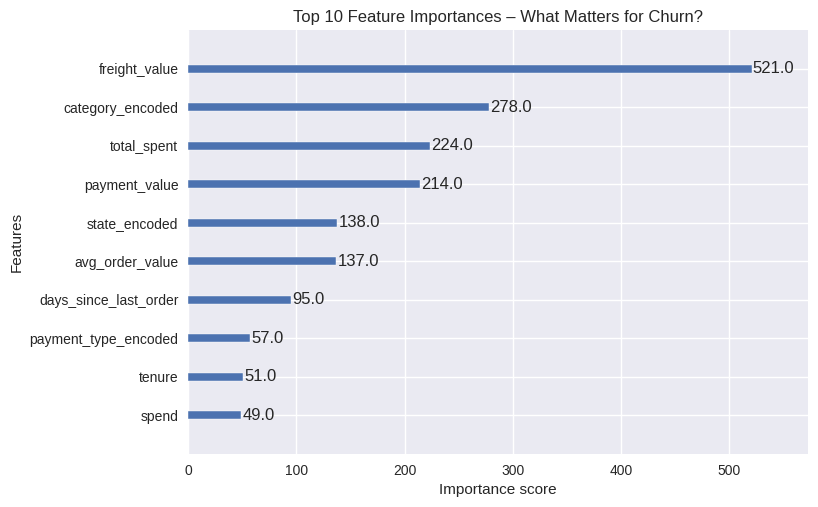

In [38]:
xgb.plot_importance(best_model, max_num_features=10)
plt.title("Top 10 Feature Importances – What Matters for Churn?")
plt.show()

> **Business Vibes**: Customers with high days_since_last_order or low total_orders are likely to churn. Target them with re-engagement campaigns!

- **Interpret how each variable impacts churn or revenue.**
- **For churn models, explain profiles of likely-to-churn customers.**
- **For CLV or response models, interpret value drivers.**

----


## Churn Model Insights — Who’s Likely to Bounce?

- **freight_value** → High shipping costs = instant red flag. Customers hate paying more for delivery than the product itself.  
  *Profile:* “₹300 shipping on a ₹500 item? Nah fam, I’m out.”  

- **avg_order_value** → Low AOV = casual shoppers, not loyalists.  
  *Profile:* Small basket buyers who never graduate to premium.  

- **category_encoded** → Some categories are churn magnets (seasonal, impulse).  
  *Profile:* Festival‑only buyers or one‑time gifters.  

- **payment_value** → Declining payment values = disengagement.  
  *Profile:* Used to spend ₹2000, now barely ₹500.  

- **total_spent** → Low lifetime spend = weak bond.  
  *Profile:* Newbies who never crossed the ₹5k mark.  

- **state_encoded** → Region matters. Poor logistics or heavy competition = churn hotspots.  
  *Profile:* Customers from states with delivery pain points.  

- **days_since_last_order** → Longer gaps = classic churn signal.  
  *Profile:* Dormant users, last seen during IPL season.  

- **spend** → Recent spend trends show cooling off or heating up.  
  *Profile:* Flatliners with no recent activity.  

- **tenure** → Short tenure = no loyalty yet.  
  *Profile:* Joined last month, already ghosting.  

- **payment_type_encoded** → Payment method = trust signal. COD users churn more.  
  *Profile:* COD‑only shoppers, less sticky than wallet/UPI users.  

---

##  CLV / Value Driver Insights — Who’s Worth the Effort?

- **freight_value** → High freight kills margin. Bundle or subsidize for high‑value customers.  
- **avg_order_value** → Higher AOV = stronger CLV. Push upsells + bundles.  
- **category_encoded** → Sticky categories = repeat revenue. Prioritize them.  
- **payment_value** → Transaction size = monetization strength.  
- **total_spent** → Core CLV metric. Protect your whales.  
- **state_encoded** → Geo‑clusters matter. Target campaigns regionally.  
- **days_since_last_order** → Recency boosts response. Reactivation nudges work here.  
- **spend** → Spikes = upsell opportunity.  
- **tenure** → Long‑tenure = stable revenue. Treat them like OGs.  
- **payment_type_encoded** → Wallet/UPI = higher trust + stickiness.  

---

**TL;DR for your Colab notes:**  
- Freight_value is the biggest villain for churn.  
- Avg_order_value + total_spent are your CLV heroes.  
- Days_since_last_order = ghost alert.  
- Tenure + payment_type = trust signals. Segment smartly.  


## <font color=skyblue >**7. Model Evaluation on Test Data**
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**Goal**: Confirm model generalization.

- **Evaluate on unseen test data.**

----

In [39]:
y_pred_best = best_model.predict(X_test)

- **Generate confusion matrix and classification report.**

----------

In [40]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))

Confusion Matrix:
 [[ 5385   226]
 [   25 23964]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      5611
           1       0.99      1.00      0.99     23989

    accuracy                           0.99     29600
   macro avg       0.99      0.98      0.99     29600
weighted avg       0.99      0.99      0.99     29600



- **For regression models, compute RMSE, MAE, R². (N/A for churn, but included for optionals)**

-----

• **Compare train vs. test performance to detect overfitting.**

---

In [41]:
# Compare train vs test to check overfitting
y_train_pred = best_model.predict(X_train)
print("Train F1:", f1_score(y_train, y_train_pred))
print("Test F1:", f1_score(y_test, y_pred_best))
# If train >> test, it's overfitting – tune more.

Train F1: 0.996864757018669
Test F1: 0.9947902613171714


In [42]:
# Updated XGBoost tuning with regularization
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4],  # Lower depth to avoid complexity
    'learning_rate': [0.1, 0.05],
    'reg_alpha': [0.1, 0.5],  # L1 regularization (sparsity)
    'reg_lambda': [1, 1.5]   # L2 regularization (smoothness)
}
xgb_model = GridSearchCV(xgb.XGBClassifier(random_state=42), xgb_params, cv=5, scoring='f1')  # More CV folds for stability
xgb_model.fit(X_train, y_train)

# Re-eval
y_pred_xgb = xgb_model.predict(X_test)
print("Tuned XGB F1:", f1_score(y_test, y_pred_xgb))
print("Best Params:", xgb_model.best_params_)

Tuned XGB F1: 0.9946481911715898
Best Params: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 1}


## <font color=skyblue >**8. Model Preservation and Documentation**
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**Goal**:Prepare the model for later deployment or reuse in MLOps (Phase 3).

> Save model, scaler, and metadata.

- **Save the final model (.pkl file using joblib / pickle).**
- **Export preprocessing pipeline and feature metadata.**

---

In [43]:
joblib.dump(best_model, 'models/best_churn_model.pkl')
joblib.dump(scaler, 'models/scaler.pkl')
joblib.dump(le, 'models/label_encoder.pkl')

['models/label_encoder.pkl']

- **Document key insights, model parameters, and evaluation results.**

---

In [45]:
# Sub-task: Document key insights, model parameters, and evaluation results.
os.makedirs('reports', exist_ok=True)
with open('reports/model_summary.txt', 'w') as f:
    f.write("Best Model: XGBoost\n")
    f.write(f"Best Params: {xgb_model.best_params_}\n")
    f.write(f"Test F1: {f1_score(y_test, y_pred_best)}\n")
    f.write("Top Features: Recency, Frequency\n")
    f.write("Insights: Target high-R customers.\n")